In [286]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

tf.random.set_seed(42)
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.16.2


In [305]:
train_df = pd.read_csv(os.path.join(os.getcwd(),'data','train.csv'))

columns_to_train = [
    'Basic_Demos-Age',
    'Physical-BMI',
    'Physical-Height',
    'Physical-Weight',
    'FGC-FGC_CU',
    'SDS-SDS_Total_T',
    'PreInt_EduHx-computerinternet_hoursday',
    'sii'
]

def initial_category(sii:float):
    return 0 if sii == 0 else 1

# Let's keep only the values that contain 'sii' values
train_df = train_df.loc[:,columns_to_train]
train_df = train_df[train_df['sii'].isna() == False]
train_df['sii_initial_category'] = train_df['sii'].apply(lambda x: initial_category(x))

val_df = train_df.sample(frac=0.2, random_state=42)
train_df = train_df.drop(val_df.index)

train_df.shape, val_df.shape

((2189, 9), (547, 9))

In [303]:
train_df.head(5)

,Basic_Demos-Age,Physical-BMI,Physical-Height,Physical-Weight,FGC-FGC_CU,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii_initial_category
0,5,16.877316,46.0,50.8,0.0,NaN,3.0,1
1,9,14.035590,48.0,46.0,3.0,64.0,0.0,0
2,10,16.648696,56.5,75.6,20.0,54.0,2.0,0
3,9,18.292347,56.0,81.6,18.0,45.0,0.0,1
5,13,22.279952,59.5,112.2,12.0,56.0,0.0,1


In [306]:
def input_missing_data(df:pd.DataFrame):
    df = df.copy()
    imputer_5n=KNNImputer(n_neighbors=5)
    imputer_10n=KNNImputer(n_neighbors=10)
    imputer_50n=KNNImputer(n_neighbors=50)
    imputer_100n=KNNImputer(n_neighbors=100)
    knn_imputed=(imputer_5n.fit_transform(df) + imputer_10n.fit_transform(df) + imputer_50n.fit_transform(df) + imputer_100n.fit_transform(df)) / 4
    knn_imputed_df=pd.DataFrame(knn_imputed,columns=imputer_50n.get_feature_names_out())
    return knn_imputed_df

train_df = input_missing_data(train_df)
val_df = input_missing_data(val_df)

In [307]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2189 entries, 0 to 2188
Data columns (total 9 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Basic_Demos-Age                         2189 non-null   float64
 1   Physical-BMI                            2189 non-null   float64
 2   Physical-Height                         2189 non-null   float64
 3   Physical-Weight                         2189 non-null   float64
 4   FGC-FGC_CU                              2189 non-null   float64
 5   SDS-SDS_Total_T                         2189 non-null   float64
 6   PreInt_EduHx-computerinternet_hoursday  2189 non-null   float64
 7   sii                                     2189 non-null   float64
 8   sii_initial_category                    2189 non-null   float64
dtypes: float64(9)
memory usage: 154.0 KB


<Axes: ylabel='Frequency'>

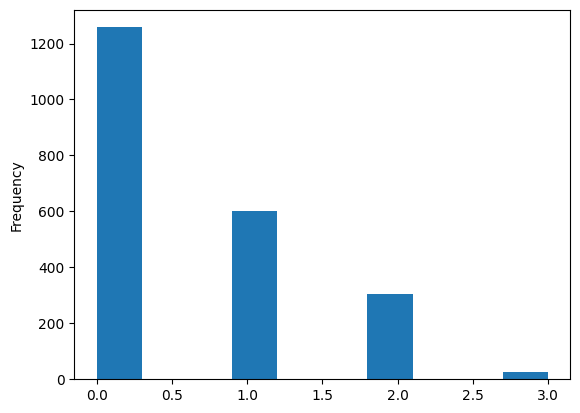

In [308]:
train_df['sii'].plot(kind='hist')

In [291]:
def dataframe_to_dataset(df:pd.DataFrame):
    df = df.copy()
    labels = df.pop('sii_initial_category')
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    ds = ds.shuffle(buffer_size=len(df))
    return ds

train_ds = dataframe_to_dataset(train_df)
val_ds = dataframe_to_dataset(val_df)

In [292]:
for x,y in train_ds.take(1):
    print("Input:", x)
    print("Label:", y)

Input: {'Basic_Demos-Age': <tf.Tensor: shape=(), dtype=float64, numpy=16.0>, 'Physical-BMI': <tf.Tensor: shape=(), dtype=float64, numpy=18.36408163>, 'Physical-Height': <tf.Tensor: shape=(), dtype=float64, numpy=70.0>, 'Physical-Weight': <tf.Tensor: shape=(), dtype=float64, numpy=128.0>, 'FGC-FGC_CU': <tf.Tensor: shape=(), dtype=float64, numpy=33.0>, 'SDS-SDS_Total_T': <tf.Tensor: shape=(), dtype=float64, numpy=55.035>, 'PreInt_EduHx-computerinternet_hoursday': <tf.Tensor: shape=(), dtype=float64, numpy=3.0>}
Label: tf.Tensor(1.0, shape=(), dtype=float64)


2024-10-29 23:57:48.587045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [293]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [294]:
def encode_numerical_features(feature, name, dataset):
    # Create a Normalization layer for our numerical feature
    normalizer = tf.keras.layers.Normalization()
    
    # We get the feature from our dataset
    feature_ds = dataset.map(lambda x,_: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x,-1))
    
    normalizer.adapt(feature_ds)
    
    encoded_feature = normalizer(feature)
    return encoded_feature

In [295]:
# Numerical features
age = tf.keras.Input(shape=(1,),name="Basic_Demos-Age")
bmi = tf.keras.Input(shape=(1,),name="Physical-BMI")
height = tf.keras.Input(shape=(1,),name="Physical-Height")
weight = tf.keras.Input(shape=(1,),name="Physical-Weight")
fgc = tf.keras.Input(shape=(1,),name="FGC-FGC_CU")
sds = tf.keras.Input(shape=(1,),name="SDS-SDS_Total_T")
internet = tf.keras.Input(shape=(1,),name="PreInt_EduHx-computerinternet_hoursday")


age_encoded = encode_numerical_features(age, "Basic_Demos-Age", train_ds)
bmi_encoded = encode_numerical_features(bmi, "Physical-BMI", train_ds)
height_encoded = encode_numerical_features(height, "Physical-Height", train_ds)
weight_encoded = encode_numerical_features(weight, "Physical-Weight", train_ds)
fgc_encoded = encode_numerical_features(fgc, "FGC-FGC_CU", train_ds)
sds_encoded = encode_numerical_features(sds, "SDS-SDS_Total_T", train_ds)
internet_encoded = encode_numerical_features(internet, "PreInt_EduHx-computerinternet_hoursday", train_ds)

all_inputs = [age,bmi,height,weight,fgc,sds,internet]

all_features = tf.keras.layers.concatenate([
	age_encoded,
	bmi_encoded,
	height_encoded,
	weight_encoded,
	fgc_encoded,
	sds_encoded,
	internet_encoded
])


x = tf.keras.layers.Dense(256, activation='relu')(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(all_inputs, output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.Accuracy()])
model.summary()

AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'StandardScaler'

In [269]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds, verbose=1)

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - auc: 0.7446 - loss: 0.5895 - val_accuracy: 0.0000e+00 - val_auc: 0.7373 - val_loss: 0.5836
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - auc: 0.7529 - loss: 0.5847 - val_accuracy: 0.0000e+00 - val_auc: 0.7434 - val_loss: 0.5802
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - auc: 0.7571 - loss: 0.5791 - val_accuracy: 0.0000e+00 - val_auc: 0.7427 - val_loss: 0.5821
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - auc: 0.7508 - loss: 0.5832 - val_accuracy: 0.0000e+00 - val_auc: 0.7433 - val_loss: 0.5795
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - auc: 0.7519 - loss: 0.5835 - val_accuracy: 0.0000e+00 - val_auc: 0.7377 - val_loss: 0.5877
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - auc: 0.7550 - loss: 0.5829 - val_accuracy: 0.0000e+00 - val_auc: 0.7476 - val_loss: 0.5781
Epoc

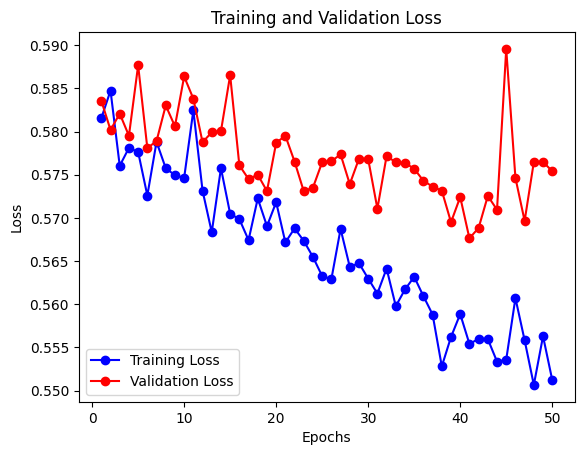

In [270]:
import matplotlib.pyplot as plt

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [271]:
import collections
predictions = model.predict(val_ds).ravel()
#counter = collections.Counter(predictions)
#counter
predictions

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([9.11553979e-01, 4.92480904e-01, 8.38457108e-01, 2.39383772e-01,
       1.11801013e-01, 2.38536477e-01, 6.84836864e-01, 1.88896671e-01,
       2.42617622e-01, 6.17381990e-01, 4.02283281e-01, 8.97174105e-02,
       1.70708358e-01, 6.05681717e-01, 3.66511136e-01, 5.95522761e-01,
       3.43939602e-01, 1.01065747e-01, 5.36357641e-01, 5.06324291e-01,
       2.51791328e-01, 7.30775774e-01, 1.78896904e-01, 2.45123789e-01,
       5.14247954e-01, 8.78248960e-02, 2.21970499e-01, 1.91522151e-01,
       4.34579849e-01, 4.58385170e-01, 1.37817591e-01, 5.02880394e-01,
       2.33541712e-01, 5.51588178e-01, 1.28110304e-01, 1.81551367e-01,
       6.58022165e-01, 4.75106180e-01, 3.78808767e-01, 6.17456198e-01,
       1.61136940e-01, 1.08301267e-01, 5.91505229e-01, 2.69578874e-01,
       1.40063465e-01, 1.00884192e-01, 2.39906266e-01, 4.83990431e-01,
       1.14521049e-01, 9.10290301e-01, 8.28597546e-01, 2.05119371e-01,
       3.00751746e-01, 5.03113389e-01, 2.46256396e-01, 3.77601683e-01,
      

In [272]:
# Try with a more complex model
tf.keras.backend.clear_session(
    free_memory=True
)
x = tf.keras.layers.Dense(256, activation='relu')(all_features)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(all_inputs, output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Accuracy()])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Basic_Demos-Age     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Physical-BMI        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Physical-Height     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Physical-Weight     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FGC-FGC_CU          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SDS-SDS_Total_T     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PreInt_EduHx-compu… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 1)         │          3 │ Basic_Demos-Age[… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 1)         │          3 │ Physical-BMI[0][… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 1)         │          3 │ Physical-Height[… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 1)         │          3 │ Physical-Weight[… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_4     │ (None, 1)         │          3 │ FGC-FGC_CU[0][0]  │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_5     │ (None, 1)         │          3 │ SDS-SDS_Total_T[… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_6     │ (None, 1)         │          3 │ PreInt_EduHx-com… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 7)         │          0 │ normalization[0]… │
│ (Concatenate)       │                   │            │ normalization_1[… │
│                     │                   │            │ normalization_2[… │
│                     │                   │            │ normalization_3[… │
│                     │                   │            │ normalization_4[… │
│                     │                   │            │ normalization_5[… │
│                     │                   │            │ normalization_6[

 Total params: 135,190 (528.11 KB)

 Trainable params: 134,657 (526.00 KB)

 Non-trainable params: 533 (2.11 KB)

Epoch 1/10


/Users/lucaswerner/Desktop/projects/kaggle/child_mind_institute/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Basic_Demos-Age', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'FGC-FGC_CU', 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday']. Received: the structure of inputs={'Basic_Demos-Age': '*', 'Physical-BMI': '*', 'Physical-Height': '*', 'Physical-Weight': '*', 'FGC-FGC_CU': '*', 'SDS-SDS_Total_T': '*', 'PreInt_EduHx-computerinternet_hoursday': '*'}
  warnings.warn(
/Users/lucaswerner/Desktop/projects/kaggle/child_mind_institute/.venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.0000e+00 - auc: 0.7077 - loss: 0.6277 - val_accuracy: 0.0000e+00 - val_auc: 0.7033 - val_loss: 0.9116
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - auc: 0.7261 - loss: 0.6049 - val_accuracy: 0.0000e+00 - val_auc: 0.7258 - val_loss: 0.6740
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - auc: 0.7591 - loss: 0.5760 - val_accuracy: 0.0000e+00 - val_auc: 0.7200 - val_loss: 0.6031
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - auc: 0.7541 - loss: 0.5832 - val_accuracy: 0.0000e+00 - val_auc: 0.7307 - val_loss: 0.5929
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - auc: 0.7510 - loss: 0.5809 - val_accuracy: 0.0000e+00 - val_auc: 0.7355 - val_loss: 0.5856
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - auc: 0.7530 - loss: 0.5835 - val_accuracy: 0.0000e+00 - val_auc: 0.7298 - val_loss: 0.6020
Epoch 7/10
69/6

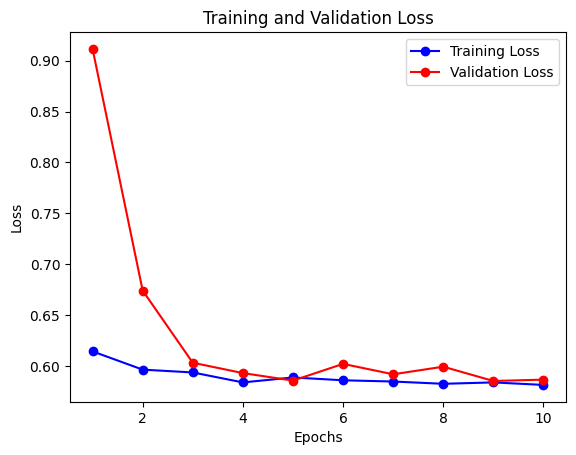

In [273]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds, verbose=1)

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [282]:
predictions = model.predict(val_ds).ravel()
threshold = 0.5
predicted_classes = tf.where(predictions >= threshold, 1, 0) 

 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [283]:
val_targets = val_ds.unbatch().map(lambda x,y: y)
val_targets = list(val_targets.as_numpy_iterator())

count=0
for target, prediction in zip(val_targets,predicted_classes):
    if target != prediction:
        count+=1
        #print("Target: ", target, " Prediction:", prediction)
print('Total incorrect: ',count, " out of: ", len(val_targets))

2024-10-29 23:57:09.260021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Total incorrect:  230  out of:  547
